# Load require package for analysis task

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
# from sklearn.model_selection import GridSearchCV
import seaborn as sns

#from sklearn.model_selection import train_test_split
from sklearn import neural_network
from sklearn import preprocessing
from sklearn import svm
from sklearn import metrics
from sklearn import tree

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Load data

In [2]:
# Load fare and trip data

data_dir = './data/'
trip = pd.read_csv(data_dir + 'trip_data_4.csv')
fare = pd.read_csv(data_dir + 'trip_fare_4.csv')

C:\USERDATA\nakk1\My Documents\anaconda\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Check data size
trip.shape
# (15100468, 14)
fare.shape
# (15100468, 11)

(15100468, 11)

## Attributes available in the dataset

In [4]:
trip.columns

Index(['medallion', ' hack_license', ' vendor_id', ' rate_code',
       ' store_and_fwd_flag', ' pickup_datetime', ' dropoff_datetime',
       ' passenger_count', ' trip_time_in_secs', ' trip_distance',
       ' pickup_longitude', ' pickup_latitude', ' dropoff_longitude',
       ' dropoff_latitude'],
      dtype='object')

In [5]:
fare.columns

Index(['medallion', ' hack_license', ' vendor_id', ' pickup_datetime',
       ' payment_type', ' fare_amount', ' surcharge', ' mta_tax',
       ' tip_amount', ' tolls_amount', ' total_amount'],
      dtype='object')

In [6]:
# Common id to join both table is 'medallion' and ' hack_license'
np.unique(trip[['medallion',' hack_license']]).shape  #(46573,)
np.unique(fare[['medallion',' hack_license']]).shape  #(46573,)

(46573,)

## Busiest Hour of the day

In [19]:
hour_var = pd.to_datetime(trip[' pickup_datetime']).dt.hour
hour_var.value_counts()

19    950590
18    922177
20    917030
21    881281
22    852428
14    755502
23    742929
17    739273
12    736474
9     725640
13    723050
15    720818
8     710687
11    704813
10    689784
16    602775
7     581624
0     571022
1     412951
6     319629
2     309334
3     223655
4     163405
5     143597
Name:  pickup_datetime, dtype: int64

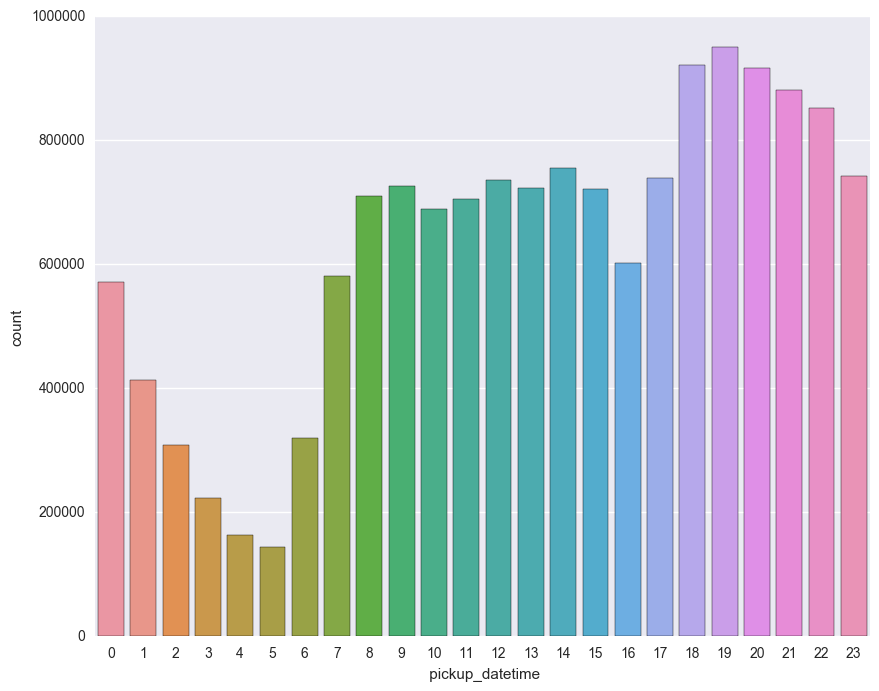

In [17]:
sns.countplot(pd.to_datetime(trip[' pickup_datetime']).dt.hour)

# Top 5 busiest hour of the day:
As shown in the chart and table above top 5 hours of the days are

    hour   pickup_count
    19     950590
    18     922177
    20     917030
    21     881281
    22     852428


## Top 10 Busiest Locations of the city

In [3]:
# Merge corrdinates together to group similar location together
trip['combined'] = trip[' pickup_longitude'].astype(str) +','+ trip[' pickup_latitude'].astype(str)

In [4]:
# We can clearly see that there are invalid trip location (deleted those we will have the top 10 location)
trip['combined'].value_counts().head(10)

0.0,0.0                 250458
-74.023048,40.765991      6859
-73.949043,40.744915       853
-73.990944,40.736053       853
-73.917358,40.670559       391
0.0,41.453693              251
-73.883629,40.63221        239
-74.195213,40.548466       157
0.0,40.754341              145
-73.965012,40.755657       130
Name: combined, dtype: int64

In [13]:
selected_trip = trip.loc[(trip[' pickup_longitude'] >= -74.2) &(trip[' pickup_longitude'] <= -73.85) &(trip[' pickup_latitude'] >= 40.5)&(trip[' pickup_latitude'] <= 40.85) ]
top_city_trip = selected_trip['combined'].value_counts().head(10)

From the above count of unique lat long of each pick up location,
we can see that the top 10 most busiest location are listed at the top.
Notice there are 0 , 0 latitude and longitude . This is likely to be data error or location is not registered at the point to trip was made. (this include with neither 0 in latitude or longitude.) So excluding those the top me location's latitude longitude is:

    Top 10 Location           Count
    -74.023048,40.765991      6859
    -73.990944,40.736053       853
    -73.949043,40.744915       853
    -73.917358,40.670559       391
    -73.883629,40.63221        239
    -74.195213,40.548466       157
    -73.965012,40.755657       130
    -73.985542,40.722073        93
    -73.954109,40.750622        85
    -73.972855,40.724857        80
    
Considering the boundary of NYC (from google map)

longitude span from -74.2 to -73.85 and

latitude span from 40.5 to 40.85

Any location that is outside of this defined boundary will not be count as within the city.


## Which trip has the highest standard deviation of travel time?
assumption: considering this question is following from the previous question. (only consider top 10 busiest city trip)

In [14]:
trip['trip_id'] = trip[' pickup_longitude'].astype(str) +','+ trip[' pickup_latitude'].astype(str) #+','+ trip[' dropoff_longitude'].astype(str)+','+ trip[' dropoff_latitude'].astype(str)  

In [15]:
# Only select top 10 trip in the city
top_list = top_city_trip.index.values.tolist()
sub_trip = trip[trip['trip_id'].isin(top_list)]

In [16]:
sub_trip.groupby('trip_id')[' trip_time_in_secs'].agg(np.std).fillna(sub_trip.groupby('trip_id')[' trip_time_in_secs'].last()).sort_values(ascending=False)

trip_id
-74.195213,40.548466    596.854970
-73.965012,40.755657    581.714202
-73.990944,40.736053    564.457471
-73.972855,40.724857    546.773216
-73.917358,40.670559    532.496762
-74.023048,40.765991    520.101536
-73.883629,40.63221     473.568054
-73.985542,40.722073    454.671801
-73.954109,40.750622    443.622572
-73.949043,40.744915    442.252581
Name:  trip_time_in_secs, dtype: float64

Trips from the 6th busiest location in the city has the highest standard deviation of travel time. (Over 157 trips)

## Which trip has most consistent fares?
Taking the same assumption here, find out the most consistent fares of the top 10 location in the city.

In [6]:
combine = pd.concat([trip, fare.drop(' pickup_datetime', 1)], axis=1, join='inner')

In [5]:
combine['trip_id'] = combine[' pickup_longitude'].astype(str) +','+ combine[' pickup_latitude'].astype(str)#+','+ combine[' dropoff_longitude'].astype(str)+','+ combine[' dropoff_latitude'].astype(str)  

In [19]:
combine_top = combine[combine['trip_id'].isin(top_list)]
combine_top.groupby('trip_id')[' fare_amount'].agg(np.std).fillna(combine_top.groupby('trip_id')[' fare_amount'].last()).sort_values()

trip_id
-73.949043,40.744915     6.904955
-73.954109,40.750622     6.942173
-73.883629,40.63221      7.953511
-73.990944,40.736053     8.361611
-74.195213,40.548466     8.375482
-73.985542,40.722073     8.529200
-73.965012,40.755657     9.362956
-74.023048,40.765991     9.800604
-73.917358,40.670559    10.233113
-73.972855,40.724857    10.520256
Name:  fare_amount, dtype: float64

Trips from the 2nd most busiest location (equal second) has the most consistent fares (over 853 trips)

# Open Question:
## a. In what trips can you confidently use respective means as measures of central tendency to estimate fare, time taken, etc.
In order to confidently use respective means as measures of central tendency, we will need to check 
1. Shape of the distribution
2. Outliers

As mean is relatively sensitive to both of them. Therefore ultimately, we will need to make sure we understand the distribution and the amount of outliers of the variable we want to estimate.

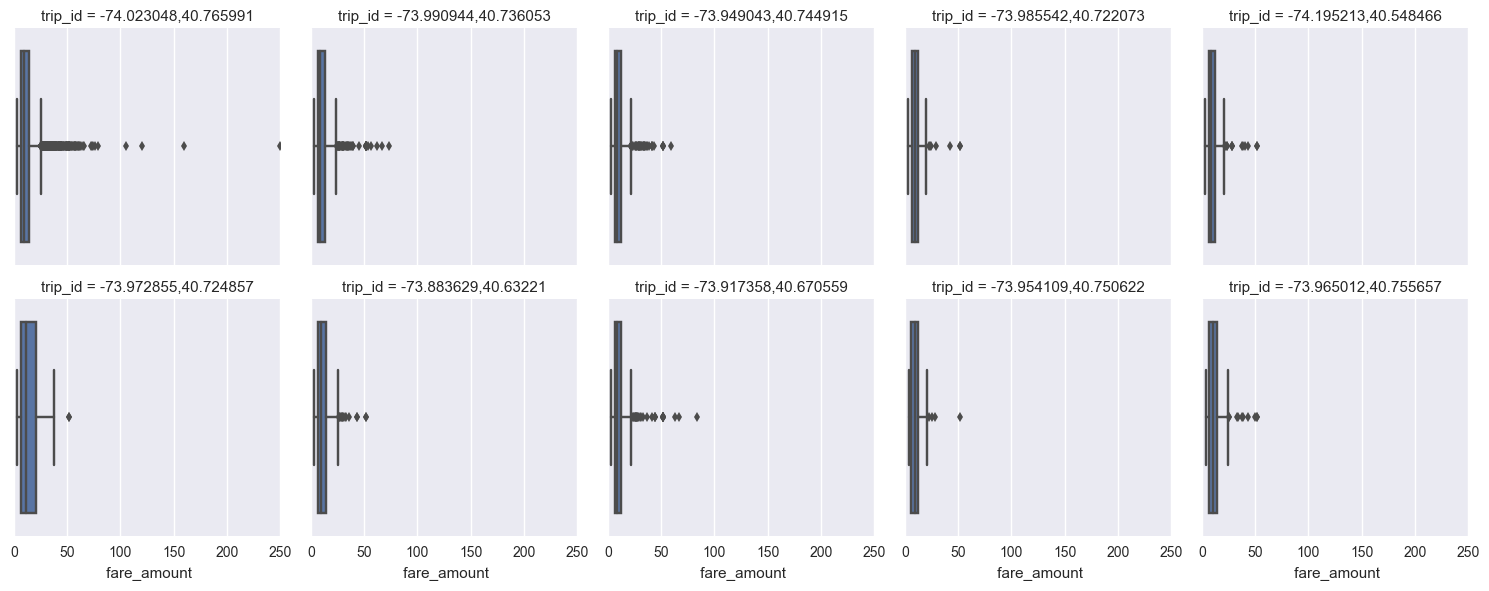

In [26]:
# Taking Fare as an example:
g = sns.FacetGrid(combine_top, col='trip_id', col_wrap  = 5)
g.map(sns.boxplot, " fare_amount")
sns.plt.show()

Observing from the above graph, fare amount seems to be right skewed for trip_id = -74.023048,40.765991 (first one in row one)
We can also see multiple extreme values (outliers) exists. Taking the mean will have a poor representation of the truth.
Same for the third one on row 2 (less extreme). We should either compare the median or mode with the mean to validate the use of mean. However, most of the other trip can be confidently expressed by its respective mean.

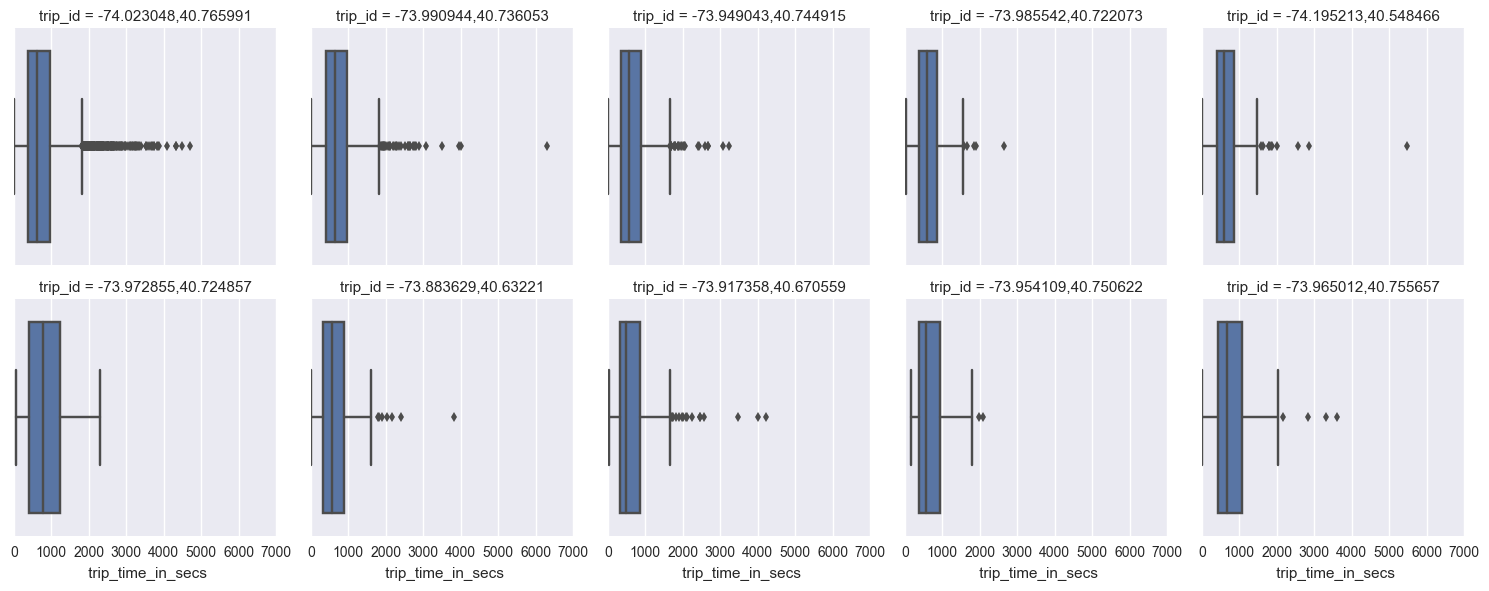

In [27]:
# Using trip duration:
g = sns.FacetGrid(combine_top, col='trip_id', col_wrap  = 5)
g.map(sns.boxplot, " trip_time_in_secs")
sns.plt.show()

Here we can see the 1st, 2nd, 5th of row 1 and 2nd,3rd and 5th from the row 2 seems to be right skewed. Removing the outliers or comparing against its mean and mode would be more appropriated.

In [8]:
combine.columns

Index(['medallion', ' hack_license', ' vendor_id', ' rate_code',
       ' store_and_fwd_flag', ' pickup_datetime', ' dropoff_datetime',
       ' passenger_count', ' trip_time_in_secs', ' trip_distance',
       ' pickup_longitude', ' pickup_latitude', ' dropoff_longitude',
       ' dropoff_latitude', 'medallion', ' hack_license', ' vendor_id',
       ' payment_type', ' fare_amount', ' surcharge', ' mta_tax',
       ' tip_amount', ' tolls_amount', ' total_amount'],
      dtype='object')

## b. Can we build a model to predict fare and tip amount given pick up and drop off coordinates, time of day and week?
We can certainly build a model to predict fare and tip amount using just pick up /drop off coordinates, time of day and week.

predicting fare is more simple as each trip would have a fare to start with. We can simply build a regression model to do so:

We can build a simple regression model:

fare = pick up coordinates + drop off coordinates + time of day + week

Note: pick up and drop off coordinates might be more useful if transformed into other features such as using both coordinates to calculate actual distance between two coordinates , or run third party google api to get drive time between the two coordinates. But for simplicity, the demonstration below will just use the corrdinates

In [9]:
# Generate hour and week column
combine['hour'] = pd.to_datetime(combine[' pickup_datetime']).dt.hour
combine['week'] = pd.to_datetime(combine[' pickup_datetime']).dt.week

In [10]:
# create model data set
df = combine[[' fare_amount',' pickup_longitude',' pickup_latitude',' dropoff_latitude',' dropoff_longitude','hour','week']]

In [11]:
# remove irregular lat long
df = df.loc[(df[' pickup_longitude'] < 0 ) & (df[' pickup_latitude'] > 0 )& (df[' dropoff_longitude'] < 0 ) & (df[' dropoff_latitude'] > 0 )]

In [11]:
# Count Number of NA's
null_list = df.isnull().sum()
null_list = null_list[~(null_list == 0)]
print(null_list)

 store_and_fwd_flag    7518657
 dropoff_longitude         146
 dropoff_latitude          146
dtype: int64


In [12]:
df = df[pd.notnull(df[' dropoff_latitude'])]
# Count Number of NA's
null_list = df.isnull().sum()
null_list = null_list[~(null_list == 0)]
print(null_list)
# small number of Na's can be removed

 store_and_fwd_flag    7518511
dtype: int64


In [15]:
# Create training data set
# for demonstration purpose just take 500,000 sample as the total data set and further cut this subset for later task
num_train = 500000
df_train = df.copy()
df_train = df_train.loc[np.random.choice(df_train.index,size=int(0.8*num_train),replace=False)]
indices = df.index[~df.index.isin(df_train.index)]
# Save this for final error metrics calculation
test = df.loc[np.random.choice(indices,size=int(0.2*num_train),replace=False)]
print(df_train.shape)
print(test.shape)

(400000, 7)
(100000, 7)


In [16]:
# first model fit
num_train = len(df_train)
train = df_train.copy()
train = train.loc[np.random.choice(train.index,size=int(0.8*num_train),replace=False)]
indices = df_train.index[~df_train.index.isin(train.index)]
val = df_train.loc[np.random.choice(indices,size=int(0.2*num_train),replace=False)]

print(train.shape)
print(val.shape)
print(test.shape)

(320000, 7)
(80000, 7)
(100000, 7)


In [20]:
# for demonstration purpose
# just fit an easy random forest model 
# further parameter tuning can be done but will not be included due to lack of time
from sklearn.ensemble import RandomForestRegressor
# for reproducible outcome
SEED = 148
np.random.seed(SEED)
rf = RandomForestRegressor(random_state=SEED, n_estimators = 10) # 10 is just an arbitrary number to demonstrate the thought process of the modelling procedure
# which can be tune further to lift model performance
y_train = train[' fare_amount']
X_train = train.drop([' fare_amount'], axis=1)


rf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=148,
           verbose=0, warm_start=False)

Feature ranking:
1. feature 3 (0.363048)
2. feature 0 (0.318149)
3. feature 2 (0.164619)
4. feature 1 (0.131346)
5. feature 4 (0.016410)
6. feature 5 (0.006427)


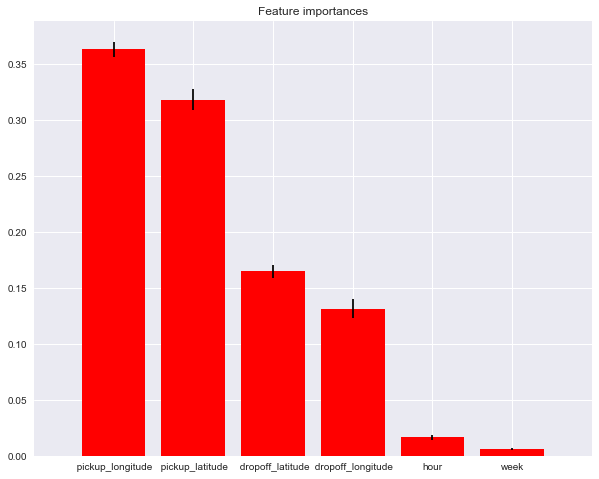

In [30]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
feature_names = X_train.columns # e.g. ['A', 'B', 'C', 'D', 'E']
plt.xticks(range(X_train.shape[1]), feature_names)
#plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [31]:
y_test = test[' fare_amount']
X_test = test.drop([' fare_amount'], axis=1)

#Print model report:
print('Model Report')
print('MSE : {}'.format(metrics.mean_squared_error(rf.predict(X_test), y_test)))
# This models gives a average MSE of 13.36 on fares
# So it is possible to build a model to predict fares.

Model Report
MSE : 13.3624064909742


In [44]:
# This model will predict the fare amount:
rf.predict(X_test)

NameError: name 'rf' is not defined

### To predict tips:
This would require a two steps process 

    1. Predicting whether a trip will incur a tip amount   (Classification problem)
    2. If its incurred how large will the tip amount be    (Regression Problem)

One could simlply obtain the prior distribution of Pr(tip) for the estimated probability of tip.
Here I will demonstrate a strategy where we mark all the trips with an indicator function:
    
    1 = tip is given
    0 = no tip is given
    

In [12]:
combine.columns

Index(['medallion', ' hack_license', ' vendor_id', ' rate_code',
       ' store_and_fwd_flag', ' pickup_datetime', ' dropoff_datetime',
       ' passenger_count', ' trip_time_in_secs', ' trip_distance',
       ' pickup_longitude', ' pickup_latitude', ' dropoff_longitude',
       ' dropoff_latitude', 'medallion', ' hack_license', ' vendor_id',
       ' payment_type', ' fare_amount', ' surcharge', ' mta_tax',
       ' tip_amount', ' tolls_amount', ' total_amount', 'trip_id', 'hour',
       'week'],
      dtype='object')

In [ ]:
# Using the previous df we create the new feature:
# create model data set
df = combine[[' tip_amount',' pickup_longitude',' pickup_latitude',' dropoff_latitude',' dropoff_longitude','hour','week']]

In [18]:
# check the tip amount and I(tip or not) distribution first:
df['tip_indicator'] = (df[' tip_amount'] > 0 )*1

C:\USERDATA\nakk1\My Documents\anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,tip_amount,fare_amount,pickup_longitude,pickup_latitude,dropoff_latitude,dropoff_longitude,hour,week,tip_indicator
0,2.50,11.0,-73.957855,40.765320,40.785648,-73.976273,18,14,1
1,1.80,8.5,0.000000,0.000000,0.000000,0.000000,7,14,1
2,3.60,16.5,-73.982880,40.754990,40.715374,-74.009186,17,14,1
3,3.45,10.0,-73.978119,40.763451,40.776642,-73.955666,18,14,1
4,3.20,15.0,-74.006371,40.744755,40.761082,-73.961662,20,14,1
5,1.10,4.5,-73.985191,40.754932,40.747997,-73.990776,2,14,1
6,1.00,6.5,-73.985168,40.763420,40.751144,-73.978867,6,14,1
7,2.10,8.0,-73.980026,40.745785,40.756168,-74.002747,6,14,1
8,2.25,7.5,-73.978477,40.761230,40.759415,-73.984566,19,14,1
9,2.80,12.5,-73.961342,40.764793,40.756004,-73.988472,18,14,1


In [25]:
# try look at the distribution of the tip indicator
df['tip_indicator'].value_counts()
# Pr( getting a tip ) = 0.521871
# Pr( not getting a tip) = 0.478129

1    7880496
0    7219972
Name: tip_indicator, dtype: int64

In [ ]:
# I will demonstrate a simple tree base classification model here:
## given that we have to use the same variable as specified in the question



In [26]:
df = df[pd.notnull(df[' dropoff_latitude'])]
# Count Number of NA's
null_list = df.isnull().sum()
null_list = null_list[~(null_list == 0)]
print(null_list)
# small number of Na's can be removed

Series([], dtype: int64)


In [27]:
# Create training data set
# for demonstration purpose just take 500,000 sample as the total data set and further cut this subset for later task
num_train = 500000
df_train = df.copy()
df_train = df_train.loc[np.random.choice(df_train.index,size=int(0.8*num_train),replace=False)]
indices = df.index[~df.index.isin(df_train.index)]
# Save this for final error metrics calculation
test = df.loc[np.random.choice(indices,size=int(0.2*num_train),replace=False)]
print(df_train.shape)
print(test.shape)

(400000, 8)
(100000, 8)


In [28]:
# first model fit
num_train = len(df_train)
train = df_train.copy()
train = train.loc[np.random.choice(train.index,size=int(0.8*num_train),replace=False)]
indices = df_train.index[~df_train.index.isin(train.index)]
val = df_train.loc[np.random.choice(indices,size=int(0.2*num_train),replace=False)]

print(train.shape)
print(val.shape)
print(test.shape)

(320000, 8)
(80000, 8)
(100000, 8)


In [55]:
# for demonstration purpose
# just fit an easy random forest model 
# further parameter tuning can be done but will not be included due to lack of time
from sklearn.ensemble import RandomForestRegressor
# for reproducible outcome
SEED = 148
np.random.seed(SEED)
rf_tip_pr = RandomForestRegressor(random_state=SEED, n_estimators = 50) # 10 is just an arbitrary number to demonstrate the thought process of the modelling procedure
# which can be tune further to lift model performance
y_train = train['tip_indicator']
X_train = train.drop([' tip_amount','tip_indicator'], axis=1)

rf_tip_pr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=148,
           verbose=0, warm_start=False)

Feature ranking:
1. feature 2 (0.217798)
2. feature 1 (0.216392)
3. feature 3 (0.214101)
4. feature 0 (0.209217)
5. feature 4 (0.083912)
6. feature 5 (0.058581)


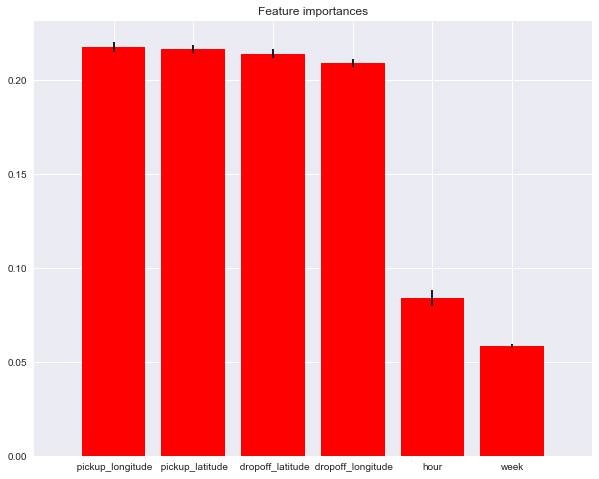

In [38]:
importances = rf_tip_pr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_tip_pr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
feature_names = X_train.columns # e.g. ['A', 'B', 'C', 'D', 'E']
plt.xticks(range(X_train.shape[1]), feature_names)
#plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

We can see the factors are more equally important when it comes to predicting prob of getting a tip

In [39]:
y_test = test['tip_indicator']
X_test = test.drop([' tip_amount','tip_indicator'], axis=1)
#Print model report:
print('Model Report')
print('AUC : {}'.format(metrics.roc_auc_score( y_test,rf_tip_pr.predict(X_test))))
# This models gives fairly low auc as it is just built based on 10 estimators.
# this could potentially lifted by further tuning and more feature manipulating of the pickup and dropoff location

Model Report
AUC : 0.6040815755104708


In [43]:
# this model will predict probability of getting a tip
rf_tip_pr.predict(X_test)

array([ 0.66,  0.68,  0.32, ...,  0.5 ,  0.48,  0.32])

## Next step
I will demonstrate how to predict the tip amount, this will be very similar with the fare amount.

In [46]:
# Using the same data set
# for demonstration purpose
# just fit an easy random forest model 
# further parameter tuning can be done but will not be included due to lack of time
from sklearn.ensemble import RandomForestRegressor
# for reproducible outcome
SEED = 148
np.random.seed(SEED)
rf_tip_amount = RandomForestRegressor(random_state=SEED, n_estimators = 50) # 10 is just an arbitrary number to demonstrate the thought process of the modelling procedure
# which can be tune further to lift model performance
y_train = train[' tip_amount']
X_train = train.drop([' tip_amount','tip_indicator'], axis=1)

rf_tip_amount.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=148,
           verbose=0, warm_start=False)

Feature ranking:
1. feature 3 (0.295512)
2. feature 0 (0.213543)
3. feature 2 (0.194057)
4. feature 1 (0.170959)
5. feature 4 (0.082927)
6. feature 5 (0.043002)


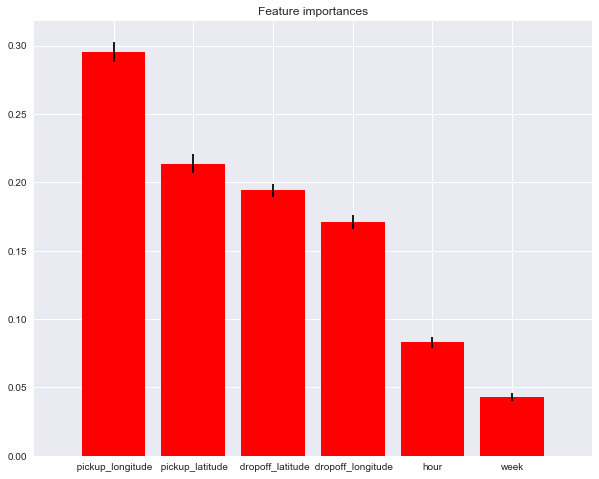

In [47]:
importances = rf_tip_amount.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_tip_amount.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
feature_names = X_train.columns # e.g. ['A', 'B', 'C', 'D', 'E']
plt.xticks(range(X_train.shape[1]), feature_names)
#plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [48]:
y_test = test[' tip_amount']
X_test = test.drop([' tip_amount','tip_indicator'], axis=1)
#Print model report:
print('Model Report')
print('MSE : {}'.format(metrics.mean_squared_error( y_test,rf_tip_amount.predict(X_test))))
# This models gives fairly low auc as it is just built based on 10 estimators.
# this could potentially lifted by further tuning and more feature manipulating of the pickup and dropoff location

Model Report
MSE : 3.231329292626615


In [51]:
# this model will predict tip amount of the trip
rf_tip_amount.predict(X_test)

array([ 1.1926,  2.8684,  0.421 , ...,  1.201 ,  1.249 ,  1.7036])

Then one can just use the following formula to get the expected tip amount a trip will get by 

$$E[Tip] = Pr( \text{Getting a tip}) \times Pred\_Tip$$

In [56]:
# which I will demonstrate on the testing data set:
tip = rf_tip_amount.predict(X_test)
p_tip = rf_tip_pr.predict(X_test)

[a*b for a,b in zip(tip,p_tip)]

[0.78711599999999993,
 1.9505120000000002,
 0.13471999999999998,
 0.68430000000000002,
 0.96335999999999999,
 0.79847999999999986,
 0.10991999999999998,
 2.2650040000000002,
 0.48754799999999993,
 0.12539999999999998,
 0.094199999999999992,
 0.75578000000000001,
 1.1506599999999996,
 0.36505199999999982,
 0.29933881602373785,
 0.76536000000000015,
 2.156256,
 1.3855759999999997,
 1.132428,
 0.65828000000000009,
 1.0491360000000001,
 0.71770400000000012,
 0.27816000000000002,
 0.64604799999999984,
 3.199716,
 0.51625599999999994,
 1.0984720000000001,
 1.0641840000000002,
 0.70644000000000007,
 1.6610399999999996,
 0.50653199999999998,
 0.27869600000000005,
 0.42643199999999992,
 1.6616599999999997,
 0.80329999999999979,
 0.42049999999999998,
 0.90635999999999994,
 0.58440000000000014,
 0.63036000000000014,
 0.79669999999999996,
 0.14660799999999999,
 0.16361999999999999,
 0.58559999999999979,
 0.14545200000000003,
 0.33193600000000001,
 0.23553599999999997,
 0.96869999999999989,
 1.3510

# Open question Part

In [23]:
# Generate hour and week column
combine = pd.concat([trip, fare.drop(['medallion', ' hack_license', ' vendor_id',' pickup_datetime'], 1)], axis=1, join='inner')
combine['hour'] = pd.to_datetime(combine[' pickup_datetime']).dt.hour
combine['week'] = pd.to_datetime(combine[' pickup_datetime']).dt.week
combine.columns

Index(['medallion', ' hack_license', ' vendor_id', ' rate_code',
       ' store_and_fwd_flag', ' pickup_datetime', ' dropoff_datetime',
       ' passenger_count', ' trip_time_in_secs', ' trip_distance',
       ' pickup_longitude', ' pickup_latitude', ' dropoff_longitude',
       ' dropoff_latitude', ' payment_type', ' fare_amount', ' surcharge',
       ' mta_tax', ' tip_amount', ' tolls_amount', ' total_amount', 'hour',
       'week'],
      dtype='object')

In [7]:
# create model data set
df = combine[[' tip_amount',' fare_amount',' pickup_longitude',' pickup_latitude',' dropoff_latitude',' dropoff_longitude','hour','week']]

In [8]:
# remove irregular lat long
df = df.loc[(df[' pickup_longitude'] < 0 ) & (df[' pickup_latitude'] > 0 )& (df[' dropoff_longitude'] < 0 ) & (df[' dropoff_latitude'] > 0 )]

In [9]:
# Count Number of NA's
null_list = df.isnull().sum()
null_list = null_list[~(null_list == 0)]
print(null_list)

Series([], dtype: int64)


In [10]:
df = df[pd.notnull(df[' dropoff_latitude'])]
# Count Number of NA's
null_list = df.isnull().sum()
null_list = null_list[~(null_list == 0)]
print(null_list)
# small number of Na's can be removed

Series([], dtype: int64)


In [11]:
# save memory
del combine

In [12]:
df['tip_indicator'] = (df[' tip_amount'] > 0 )*1

## c. If you were a taxi owner, how would you maximize your earnings in a day?
To maximize earnings in a day, according to the analysis above:
- Drive around the top 10 busiest pick up location as listed before
    - Also look at the chart attached below , we can see that locations with higher density of dots will most likely be the busiest area which will provide high number of riders (hence sustainable earnings throughout the day)
- Drive towards the location with higher consistency in fare amount more
- According to the model, latitude and longtitude of the pick up location is more important than days or week 
- However, since a taxi owner can only pick up a customer at a time, in order to maximise its earning it should aim for working at busier hours to reduce the number of hours without a rider.


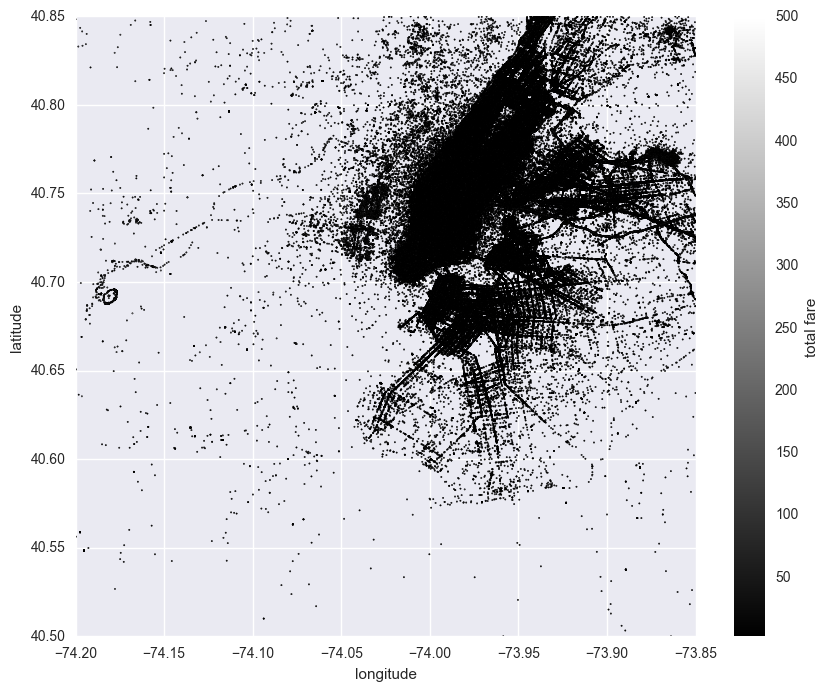

In [18]:
plt.scatter(x = ' pickup_longitude', y = ' pickup_latitude', 
            c = ' fare_amount', s =1 , data = combine_city_trip)
ax = plt.gca()
plt.colorbar(label="total fare")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.xlim(-74.2, -73.85)
plt.ylim(40.5, 40.85)

plt.show()

In [13]:
# look at a small sample 
num_train = 500000
sample = df.copy()
sample = sample.loc[np.random.choice(sample.index,size=num_train,replace=False)]
sample.columns

Index([' tip_amount', ' fare_amount', ' pickup_longitude', ' pickup_latitude',
       ' dropoff_latitude', ' dropoff_longitude', 'hour', 'week',
       'tip_indicator'],
      dtype='object')

In [54]:
combine.columns

Index(['medallion', ' hack_license', ' vendor_id', ' rate_code',
       ' store_and_fwd_flag', ' pickup_datetime', ' dropoff_datetime',
       ' passenger_count', ' trip_time_in_secs', ' trip_distance',
       ' pickup_longitude', ' pickup_latitude', ' dropoff_longitude',
       ' dropoff_latitude', ' payment_type', ' fare_amount', ' surcharge',
       ' mta_tax', ' tip_amount', ' tolls_amount', ' total_amount', 'hour',
       'week'],
      dtype='object')

## d. If you were a taxi owner, how would you minimize your work time while retaining the average wages earned by a typical taxi in the dataset?

In [43]:
avg_daily_wage = combine.groupby(' hack_license')[' fare_amount'].sum()/30

In [46]:
avg_daily_wage.mean()

186.5903271420373

In order to earn above $187 in a day in the least number of work time, we could observe the busiest hour during the day from below:
 - After 5 pm will give you the most pick up
 - while althought early hours give you higher fare sometimes, we can see leaving out the extreme values, late hours have more consistency (higher mean after 5 pm too) 
 - So if one would want to minimise working hours while earning the same amount as an average driver a day)
 - According to the numbers below one just need to work after 5 pm, and take on average 15 trips to reach the average daily wage. (that's considering all are average fare, if any fares are higher (which is more likely and consistently higher than earlier hours), the driver will only need to work than less than 15 trips. ( which has a 12 minutes trip on average)
 - This is a total of 3 hours in average.

In [53]:
# avg fare amount earn over each hour
avg_hr_earn = combine.groupby('hour')[' fare_amount'].mean()
avg_hr_earn

hour
0     12.910591
1     12.730491
2     12.665629
3     13.068987
4     14.869913
5     16.237574
6     12.659966
7     11.760516
8     11.726203
9     11.746353
10    11.808016
11    12.036239
12    12.087989
13    12.607674
14    12.888060
15    13.042917
16    12.911957
17    12.434127
18    11.804480
19    11.333642
20    11.604431
21    11.883324
22    12.207986
23    12.692478
Name:  fare_amount, dtype: float64

In [56]:
avg_hr = combine.groupby('hour')[' trip_time_in_secs'].mean()
avg_hr

hour
0     697.573892
1     665.863003
2     650.873121
3     652.883624
4     673.536165
5     656.325522
6     590.884184
7     678.049780
8     768.647887
9     777.525368
10    766.857539
11    782.667523
12    791.452795
13    811.780010
14    844.318803
15    866.409818
16    842.550716
17    825.473154
18    775.085941
19    710.441250
20    686.047738
21    676.039690
22    688.084560
23    703.889638
Name:  trip_time_in_secs, dtype: float64

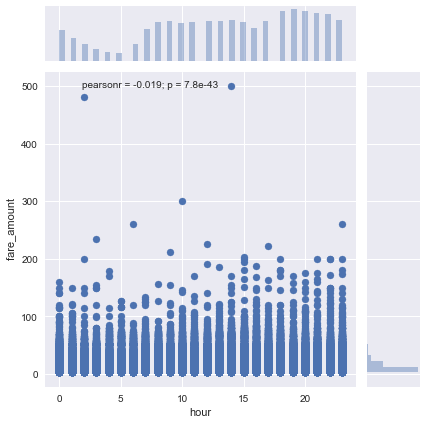

In [47]:
sns.jointplot(x="hour", y=" fare_amount", data=sample);

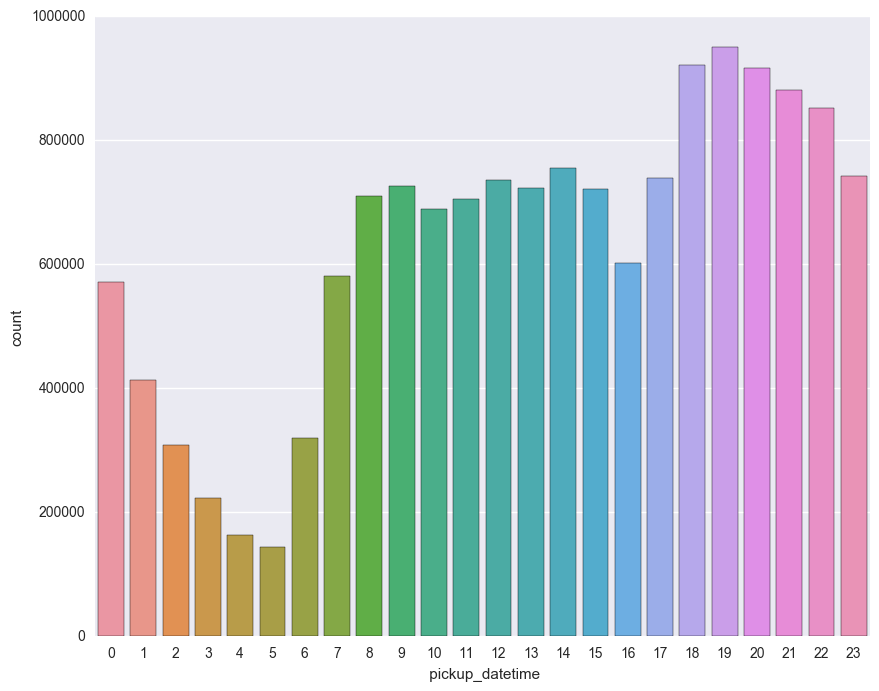

In [17]:
sns.countplot(pd.to_datetime(trip[' pickup_datetime']).dt.hour)

## e. If you run a taxi company with 10 taxis, how would you maximize your earnings?

Looking at the density chart below:
- with 10 taxis there will be 2 strategies to optimise all taxis

    1. Spread the 10 taxis optimally over NYC and manhattan area during the busiest hours of the day as according to the chart. And then during the off peak hours (less busy hours) the company could rent out the taxi so that the company can still generate an average income (rent it out at the average earning rate) so that it will be able to generate income 24/7 without any inefficient use of resources.
    2. While covering the main city will probably efficient during the busiest hours, it is likely that in less dense area in the chart below, we can see that there are still opportunity around for longer trips with higher fares. (such as heading towards the airport) 

(-74.2, -73.85)

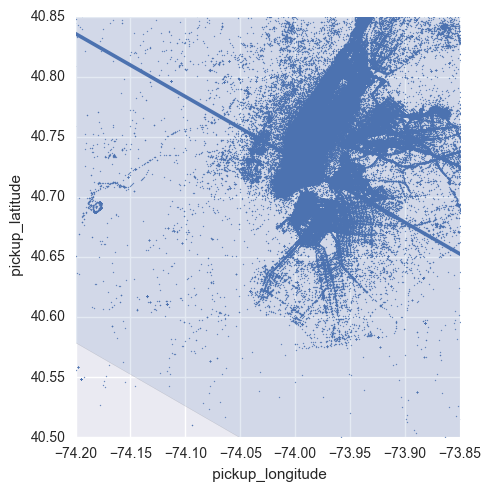

In [15]:
lm = sns.lmplot(x=' pickup_longitude', y=' pickup_latitude', data=trip, scatter_kws={"s": 1});
axes = lm.axes
axes[0,0].set_ylim(40.5, 40.85)
axes[0,0].set_xlim(-74.2, -73.85)

In [16]:
combine_city_trip = combine.loc[(combine[' pickup_longitude'] >= -74.2) &(combine[' pickup_longitude'] <= -73.85) &(combine[' pickup_latitude'] >= 40.5)&(combine[' pickup_latitude'] <= 40.85) ]

In [59]:
combine_city_trip.groupby([' pickup_longitude',' pickup_longitude'])[' fare_amount'].sum()

 pickup_longitude   pickup_longitude
-74.199974         -74.199974             70.0
-74.199791         -74.199791             80.0
-74.199722         -74.199722            155.0
-74.198433         -74.198433            140.0
-74.198219         -74.198219              7.0
-74.197449         -74.197449             98.0
-74.197372         -74.197372             52.0
-74.197029         -74.197029            135.0
-74.196594         -74.196594             16.0
-74.196434         -74.196434            227.0
-74.196259         -74.196259            100.0
-74.196068         -74.196068             94.0
-74.195213         -74.195213           1770.5
-74.194305         -74.194305            130.0
-74.194244         -74.194244             90.0
-74.194199         -74.194199            150.0
-74.194168         -74.194168            126.5
-74.193748         -74.193748            130.0
-74.193733         -74.193733             52.0
-74.193695         -74.193695            100.0
-74.193611         -74.

In [35]:
combine['trip_id'].value_counts()

0.0,0.0,0.0,0.0                              242705
-74.023048,40.765991,-74.023048,40.765991      6849
-73.949043,40.744915,-73.949043,40.744915       853
-73.990944,40.736053,-73.990944,40.736053       853
-73.917358,40.670559,-73.917358,40.670559       390
-73.883629,40.63221,-73.883629,40.63221         239
-74.195213,40.548466,-74.195213,40.548466       157
-73.965012,40.755657,-73.965012,40.755657       129
0.0,41.453693,0.0,41.453693                     103
-73.985542,40.722073,-73.985542,40.722073        91
-73.954109,40.750622,-73.954109,40.750622        85
-73.972855,40.724857,-73.972855,40.724857        79
-73.781319,40.644886,-73.781319,40.644886        77
-73.991608,40.736771,-73.991608,40.736771        74
-73.94883,40.757435,-73.94883,40.757435          71
0.0,40.754341,0.0,40.754341                      60
-73.933807,40.752392,-73.933807,40.752392        60
-73.983467,40.676632,-73.983467,40.676632        58
-73.953697,40.679832,-73.953697,40.679832        58
-73.520729,4